# Utils

In [3]:
# Libraries
import pandas as pd
import umap
import statsmodels.api as sm
import warnings
import sys
import numpy as np

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("/Users/emmatosato/Documents/PhD/ANM_Verona/src/data_processing")

# Scripts
import importlib
from analysis import umap_run, regression

importlib.reload(regression)
importlib.reload(umap_run)

from analysis.umap_run import run_umap
from preprocessing.processflat import x_features_return
from analysis.regression import main_regression, remove_missing_values, plot_ols_diagnostics, plot_actual_vs_predicted

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# FC maps directories
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps_processed = '/data/FCmaps_augmented_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"

# Path to masks
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/mask_GM.nii'

# Metadata
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/atrophy_matched.xlsx'
cognitive_dataset ='/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/cognitive_dataset.xlsx'
path_df_meta = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/meta/df_meta.csv"

# Done dataframe of preprocessed FC maps
path_df_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_gm.pkl"
path_df_thr02_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_thr02_gm.pkl"

# Parameters umap
umap_params = {'n_neighbors': 15, 'n_components': 2, 'metric': 'euclidean', 'n_epochs': 1000, 'learning_rate': 1.0, 'init': 'spectral', 'min_dist': 0.1, 'spread': 1.0, 'low_memory': False, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'a': None, 'b': None, 'random_state': 42, 'metric_kwds': None, 'angular_rp_forest': False, 'target_n_neighbors': -1, 'transform_seed': 42, 'verbose': False, 'unique': False}

# Linear Regression
- Select dataframe and target variable
- OLS
- Plot
- Shuffling

## All subjects

In [5]:
# Load data
df_gm = pd.read_pickle(path_df_gm)
df_meta = pd.read_csv(path_df_meta)

# Remove subjects with NaN values
target_col = "CDR_SB"
df_gm_regr = remove_missing_values(df_gm, df_meta, target_col)

# Features
df_merged, X = x_features_return(df_gm_regr, df_meta)

# Print shapes
print("Old shape of the dataframe (data + ID): ", df_gm.shape)
print("New shape of the dataframe (data + ID): ", df_gm_regr.shape)
print("Shape of the complete dataframe (data + ID + metadata): ", df_merged.shape)
print("Shape of the metadata (ID included): ", df_meta.shape)
print("Shape of the input data X: ", X.shape)


-------------------- Dataset Info --------------------
Meta columns (Labels and Covariates):        8
Feature matrix shape (X):                (171, 161817)
Complete dataframe shape after merge:    (171, 161825)
-------------------------------------------------------

Old shape of the dataframe (data + ID):  (176, 161818)
New shape of the dataframe (data + ID):  (171, 161818)
Shape of the complete dataframe (data + ID + metadata):  (171, 161825)
Shape of the metadata (ID included):  (176, 8)
Shape of the input data X:  (171, 161817)


In [6]:
# Reproducibility
np.random.seed(42)

# UMAP
reducer = umap.UMAP(**umap_params)
X_umap = reducer.fit_transform(X)

# Target
y = df_merged[target_col]

# Add constant (intercept)
X_with_const = sm.add_constant(X_umap)

# Fit OLS
model = sm.OLS(y, X_with_const).fit()

# Predictions and residuals
y_pred = model.predict(X_with_const)
residuals = y - y_pred

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     7.707
Date:                Wed, 18 Jun 2025   Prob (F-statistic):           0.000628
Time:                        17:20:22   Log-Likelihood:                -445.84
No. Observations:                 171   AIC:                             897.7
Df Residuals:                     168   BIC:                             907.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5135      1.161      7.332      0.0

### Plotting

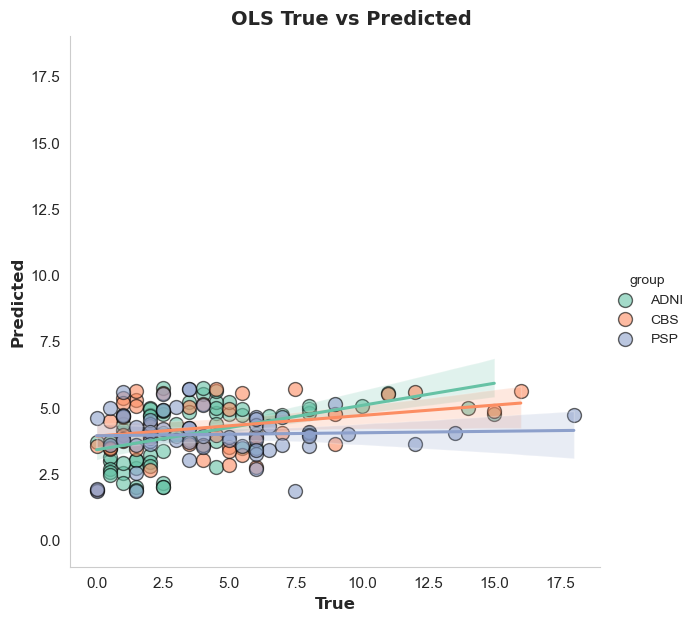

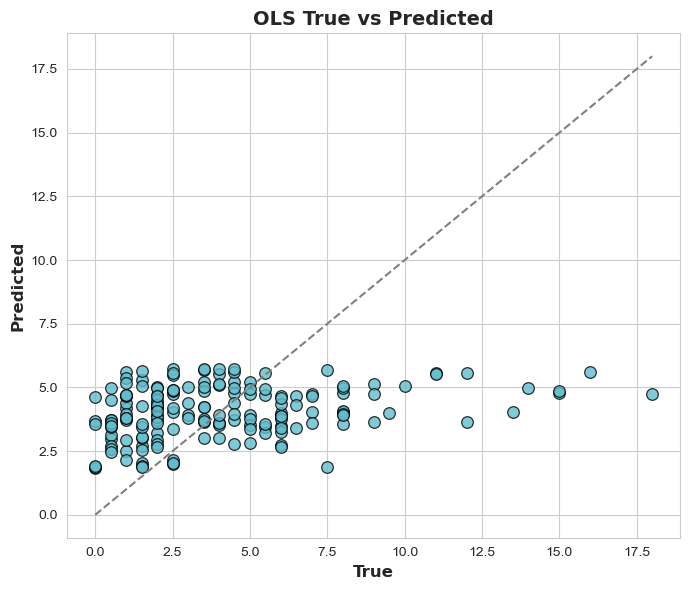

In [7]:
plot_ols_diagnostics(y, y_pred, residuals, "OLS Actual vs Predicted and Residuals",save_path=None, plot_flag=True, color_by_group=True, group_labels=df_merged['Group'])

In [8]:
#plot_actual_vs_predicted(target = y, predictions=  y_pred, "OLS Distributions", save_path=None, plot_flag=True):

### Covariates

In [9]:
config ={
    'target_variable': 'CDR_SB',
    'covariates':['Sex', 'Age', 'Education'],
    'y_log_transform': False,
    'plot_flag': True,
    'output_dir': None,
    'title_prefix': 'No Threshold',
    'color_by_group': True,
    'group_name': 'Group',
    'plot_regression': True
}

In [10]:
main_regression(df_gm, df_meta, config)

KeyError: 'plot_regression'

### Shuffling Regression

In [29]:
# R² real
r2_real = model.rsquared

# List of R² after shuffling
r2_shuffled = []

for _ in range(100):
    y_shuffled = y.sample(frac=1, replace=False, random_state=None).reset_index(drop=True)
    model_shuffled = sm.OLS(y_shuffled, X_with_const).fit()
    r2_shuffled.append(model_shuffled.rsquared)

# empiric p-value
p_value = np.mean([r >= r2_real for r in r2_shuffled])

print(f"R² real: {r2_real:.4f}")
print(f"R² shuffled: {np.mean(r2_shuffled):.4f}")
print(f"p-value (shuffling): {p_value:.4f}")

R² real: 0.0936
R² shuffled: 0.0099
p-value (shuffling): 0.0000


## Cluster K-Means

In [32]:
target_col = "CDR_SB"
cluster_col = "labels_km"

for cluster_id in df_meta[cluster_col].unique():
    print(f"\n=== Cluster {cluster_id} ===")

    # Get subject IDs for the current cluster
    ids_in_cluster = df_meta[df_meta[cluster_col] == cluster_id]["ID"]

    # Filter df_meta and df_gm_masked based on IDs only
    df_meta_cluster = df_meta[df_meta["ID"].isin(ids_in_cluster)].reset_index(drop=True)
    df_cluster = df_gm[df_gm["ID"].isin(ids_in_cluster)].reset_index(drop=True)

    # Run regression (NaN removal is handled internally)
    model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
        df_masked = df_cluster,
        df_meta = df_meta_cluster,
        target_variable = target_col,
        covariates = ['Sex', 'Age', 'Education'],
        y_log_transform = False,
        plot_flag = True,
        save_path = None,
        title_prefix = f"cluster_{cluster_col}_{cluster_id}"
    )


=== Cluster 0 ===
Dataframe shape after merge: (64, 161829)
Meta columns: 12
Feature matrix shape: (64, 161817) 

Running UMAP...



KeyError: None